[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rycroft-group/math513/blob/main/1_svd/movie_recommendation.ipynb)

In [1]:
# Necessity libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re

# How Netflix (sort of) works: Movie recommendations with SVD

Disclaimer: This activity is designed solely as an in-class demonstration of how SVD can be used to construct a toy movie recommendation system. The results do not reflect or imply students’ personal movie ratings, genre preferences, or viewing habits. This is not a real recommendation system. Real-world recommendation systems are significantly more complex and involve much larger datasets and additional modeling choices and validations.

## The dataset

Yue Sun sent out an anonymous Google Form asking students in Math/CS 513 (and her labmates/colleagues) to rate 30 movies. Ratings were given on a scale from 1 to 5, where 1 indicates "very bad/won't (re)watch" and 5 indicates "excellent/will (re)watch". The dataset contains 30 responses.

### Clean up

Clean the `.csv` files.

In [2]:
# Load in our movie rating data
data_raw = pd.read_csv('data/movie_ratings.csv', index_col=0)

# Drop empty rows
data_raw = data_raw.dropna(how='all')

# Clean up movie names
def extract_movie_title(col):
    match = re.search(r"\[(.*)\]", col)
    return match.group(1) if match else col
data_raw.columns = [extract_movie_title(col) for col in data_raw.columns]

# Remove the timestamps
data_raw.index = range(1, len(data_raw) + 1)

# Convert ratings to numeric, remove multiple ratings if any
def parse_rating(x):
    if pd.isna(x):
        return None
    nums = re.findall(r"[1-5]", str(x))
    # Remove multiple ratings, pick the highest
    return max(map(int, nums)) if nums else None
data = data_raw.applymap(parse_rating)

# Convert to numpy array
R = data.to_numpy()

### Visualize the dataset

In [3]:
from IPython.display import display
pd.set_option("display.max_columns", None)

# Display the data
display(data)

The Shining (1980)  Toy Story 1–4 (1995/1999/2010/2019)  \
1                    1                                    5   
2                    2                                    5   
3                    2                                    4   
4                    5                                    4   
5                    1                                    4   
6                    1                                    5   
7                    4                                    3   
8                    4                                    5   
9                    3                                    4   
10                   2                                    5   
11                   4                                    4   
12                   4                                    5   
13                   5                                    4   
14                   4                                    4   
15                   1                                    1   
16                   5                                    4   
17                   4                                    3   
18                   3                                    3   
19                   5                                    5   
20                   3                                    3   
21                   3                                    3   
22                   5                                    2   
23                   5                                    3   
24                   5                                    4   
25                   3                                    4   
26                   3                                    1   
27                   3                                    4   
28                   3                                    5   
29                   3                                    5   
30                   4                                    3   
31                   4                                    5   
32                   2                                    5   

    Mission: Impossible 1–8 (1996–2025)  Titanic (1997)  \
1                                     3               4   
2                                     3               2   
3                                     3               3   
4                                     5               4   
5                                     3               2   
6                                     1               1   
7                                     5               4   
8                                     2               4   
9                                     3               5   
10                                    3               4   
11                                    3               4   
12                                    4               5   
13                                    3               4   
14                                    4               4   
15                                    5               5   
16                                    2               3   
17                                    3               1   
18                                    4               3   
19                                    5               4   
20                                    3               3   
21                                    3               3   
22                                    4               4   
23                                    3               3   
24                                    3               3   
25                                    5               2   
26                                    3               2   
27                                    2               4   
28                                    3               3   
29                                    3               4   
30                                    3               3   
31                                    3               3   
32                                  

Let us first look at the average score for each movie. We will plot them in descending order and also overlay the standard deviation bar.

/var/folders/dc/yjt5l_9s0d752c4rt46gd2qh0000gn/T/ipykernel_42998/221536993.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(movie_names_sorted, rotation=45, ha='right', fontsize=7)


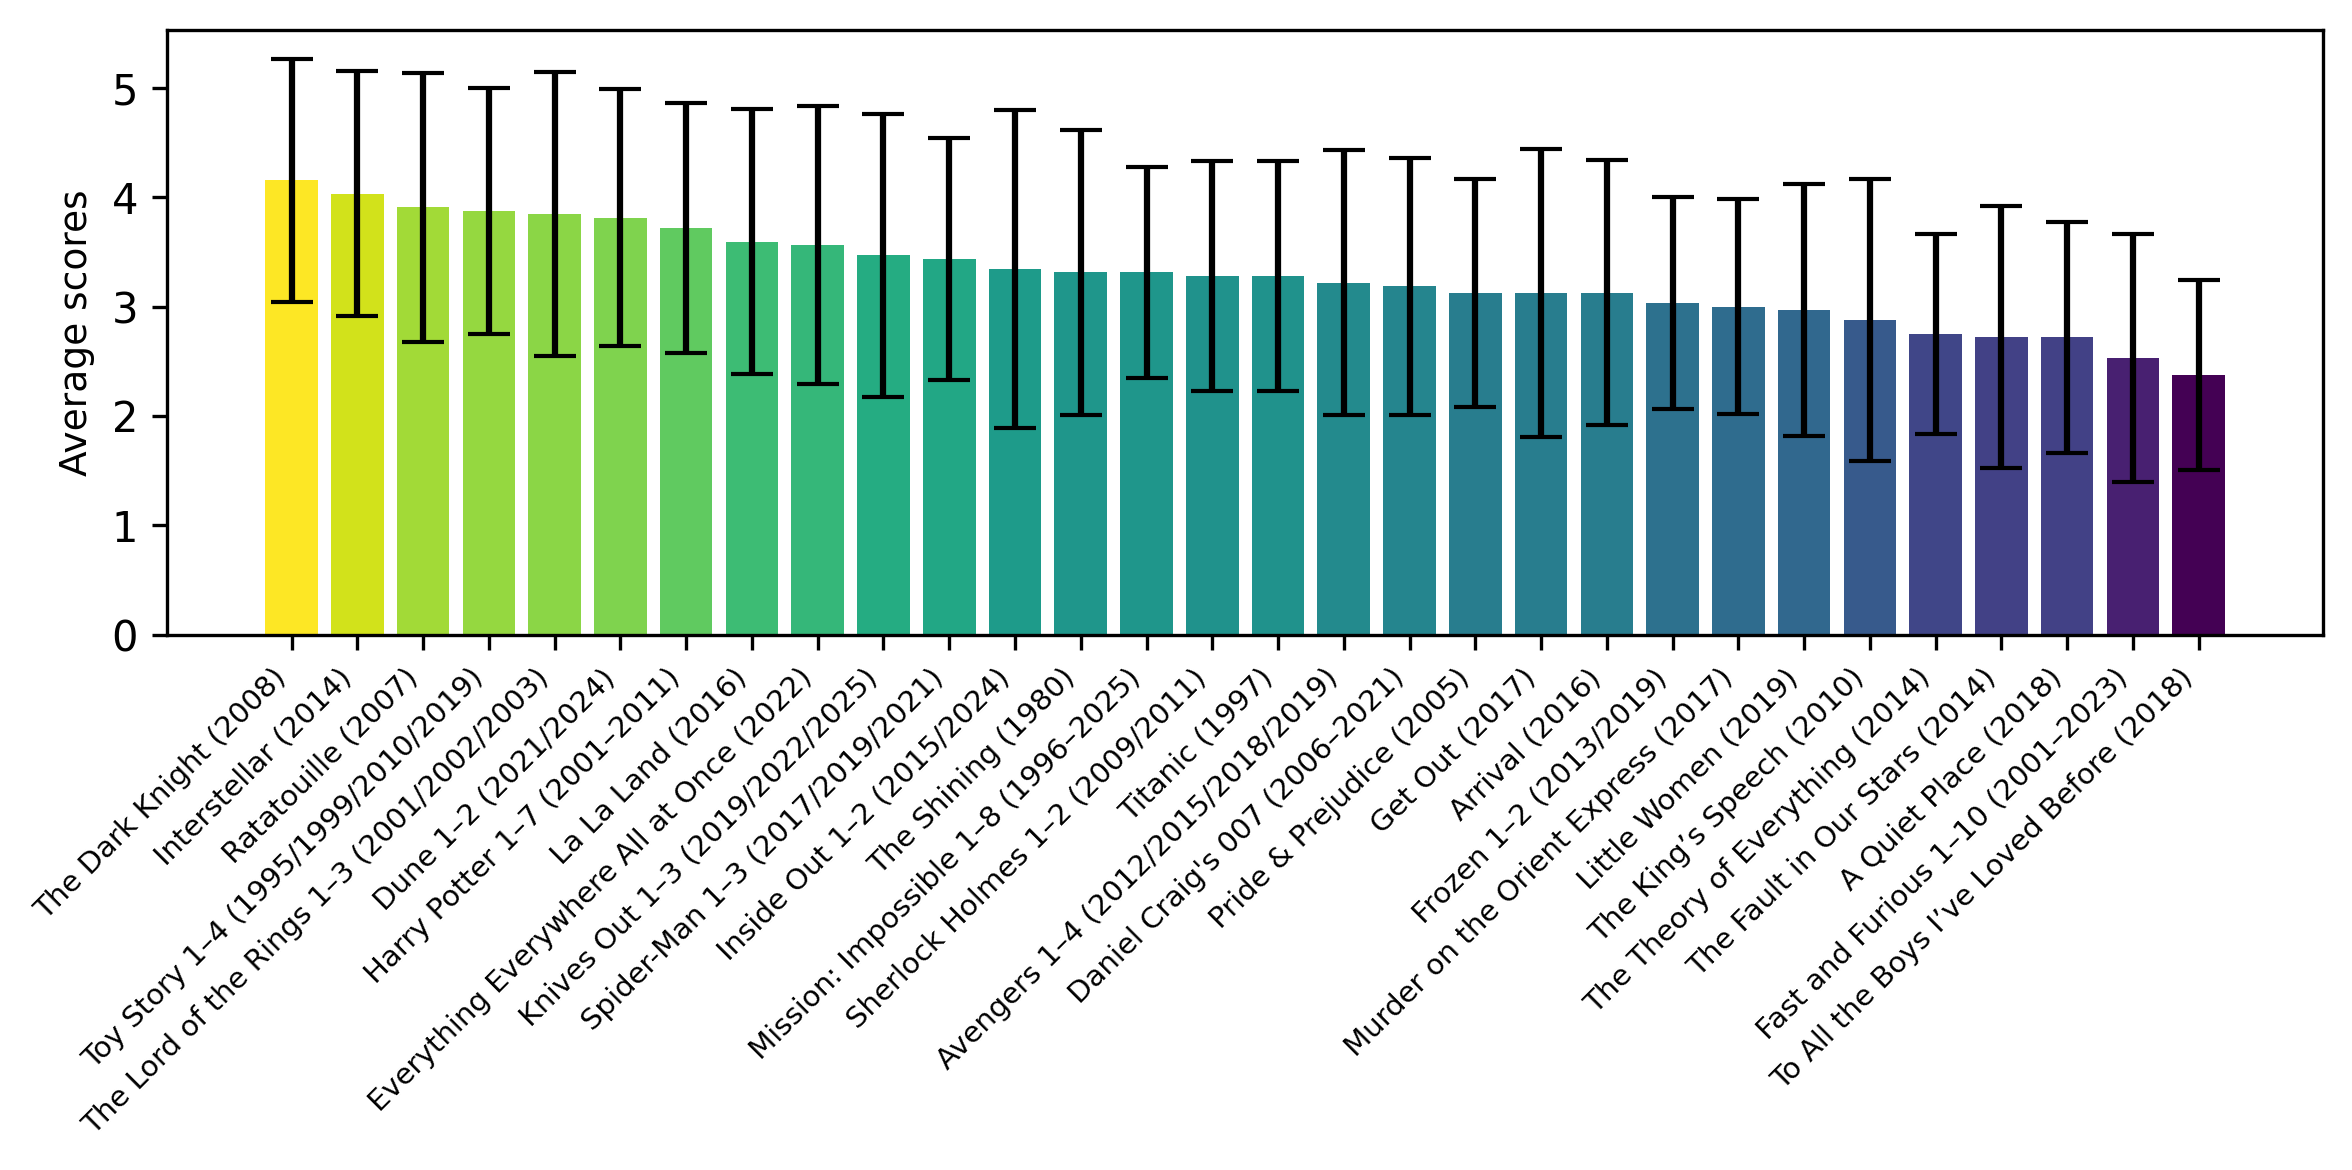

In [4]:
# Calculate the standard deviation and average score for each movie
std_scores = data.std()
avg_scores = data.mean()

# Sort movies by average scores
sorted_indices = avg_scores.sort_values(ascending=False).index
avg_scores_sorted = avg_scores[sorted_indices]
std_scores_sorted = std_scores[sorted_indices]
movie_names_sorted = sorted_indices

# Create a figure
fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=300)

# Plot average scores with error bars representing standard deviation
# Create a colormap and normalize for gradient colors
colormap = plt.cm.viridis
norm = plt.Normalize(vmin=avg_scores_sorted.min(), vmax=avg_scores_sorted.max())
colors = colormap(norm(avg_scores_sorted))

# Plot the bars with gradient colors
ax.bar(movie_names_sorted, avg_scores_sorted, yerr=std_scores_sorted, capsize=5, color=colors)

# Formatting
ax.set_ylabel('Average scores', fontsize=9)
ax.set_xticklabels(movie_names_sorted, rotation=45, ha='right', fontsize=7)

plt.tight_layout()
# plt.savefig('results/movies_mean_std.pdf', bbox_inches='tight', transparent=True)
plt.show()

While the average score and standard deviation provide insight into movie ratings, it is helpful to look at the number of votes each movie received for each score. We will make use of the rose diagram.

In [5]:
# Count votes for each score (1 to 5) for each movie
rating_counts = data.apply(lambda col: col.value_counts()).fillna(0).astype(int)
votes_per_score = rating_counts.T
votes_per_score.columns = [f"Score {i}" for i in range(1, 6)]

# Display the result
votes_per_score

Score 1  Score 2  Score 3  \
The Shining (1980)                                4        4        9   
Toy Story 1–4 (1995/1999/2010/2019)               2        1        7   
Mission: Impossible 1–8 (1996–2025)               1        3       18   
Titanic (1997)                                    2        5       10   
The Lord of the Rings 1–3 (2001/2002/2003)        3        2        5   
Harry Potter 1–7 (2001–2011)                      3        1        5   
Fast and Furious 1–10 (2001–2023)                 6       11        9   
Pride & Prejudice (2005)                          3        3       16   
Daniel Craig's 007 (2006–2021)                    4        4        9   
Ratatouille (2007)                                3        1        4   
The Dark Knight (2008)                            1        1        8   
Sherlock Holmes 1–2 (2009/2011)                   2        3       16   
The King’s Speech (2010)                          6        5       13   
Avengers 1–4 (2012/2015/2018/2019)                3        5       12   
Frozen 1–2 (2013/2019)                            3        5       12   
Interstellar (2014)                               1        2        7   
The Fault in Our Stars (2014)                     7        4       15   
The Theory of Everything (2014)                   3        7       19   
Inside Out 1–2 (2015/2024)                        6        2        8   
Arrival (2016)                                    4        4       13   
La La Land (2016)                                 2        4        8   
Get Out (2017)                                    5        4       11   
Murder on the Orient Express (2017)               2        6       17   
A Quiet Place (2018)                              5        6       16   
Spider-Man 1–3 (2017/2019/2021)                   2        3       12   
To All the Boys I’ve Loved Before (2018)          7        7       17   
Little Women (2019)                               4        5       15   
Knives Out 1–3 (2019/2022/2025)                   3        4        9   
Dune 1–2 (2021/2024)                              1        4        7   
Everything Everywhere All at Once (2022)          3        2       11   

                                            Score 4  Score 5  
The Shining (1980)                                8        7  
Toy Story 1–4 (1995/1999/2010/2019)              11       11  
Mission: Impossible 1–8 (1996–2025)               5        5  
Titanic (1997)                                   12        3  
The Lord of the Rings 1–3 (2001/2002/2003)        9       13  
Harry Potter 1–7 (2001–2011)                     16        7  
Fast and Furious 1–10 (2001–2023)                 4        2  
Pride & Prejudice (2005)                          7        3  
Daniel Craig's 007 (2006–2021)                   12        3  
Ratatouille (2007)                               12       12  
The Dark Knight (2008)                            4       18  
Sherlock Holmes 1–2 (2009/2011)                   6        5  
The King’s Speech (2010)                          3        5  
Avengers 1–4 (2012/2015/2018/2019)                6        6  
Frozen 1–2 (2013/2019)                           12        0  
Interstellar (2014)                               7       15  
The Fault in Our Stars (2014)                     3        3  
The Theory of Everything (2014)                   1        2  
Inside Out 1–2 (2015/2024)                        7        9  
Arrival (2016)                                    6        5  
La La Land (2016)                                 9        9  
Get Out (2017)                                    6        6  
Murder on the Orient Express (2017)               4        3  
A Quiet Place (2018)                              3        2  
Spider-Man 1–3 (2017/2019/2021)                   9        6  
To All the Boys I’ve Loved Before (2018)          1        0  
Little Women (2019)                               4        4  
Knives Out 1–3 (

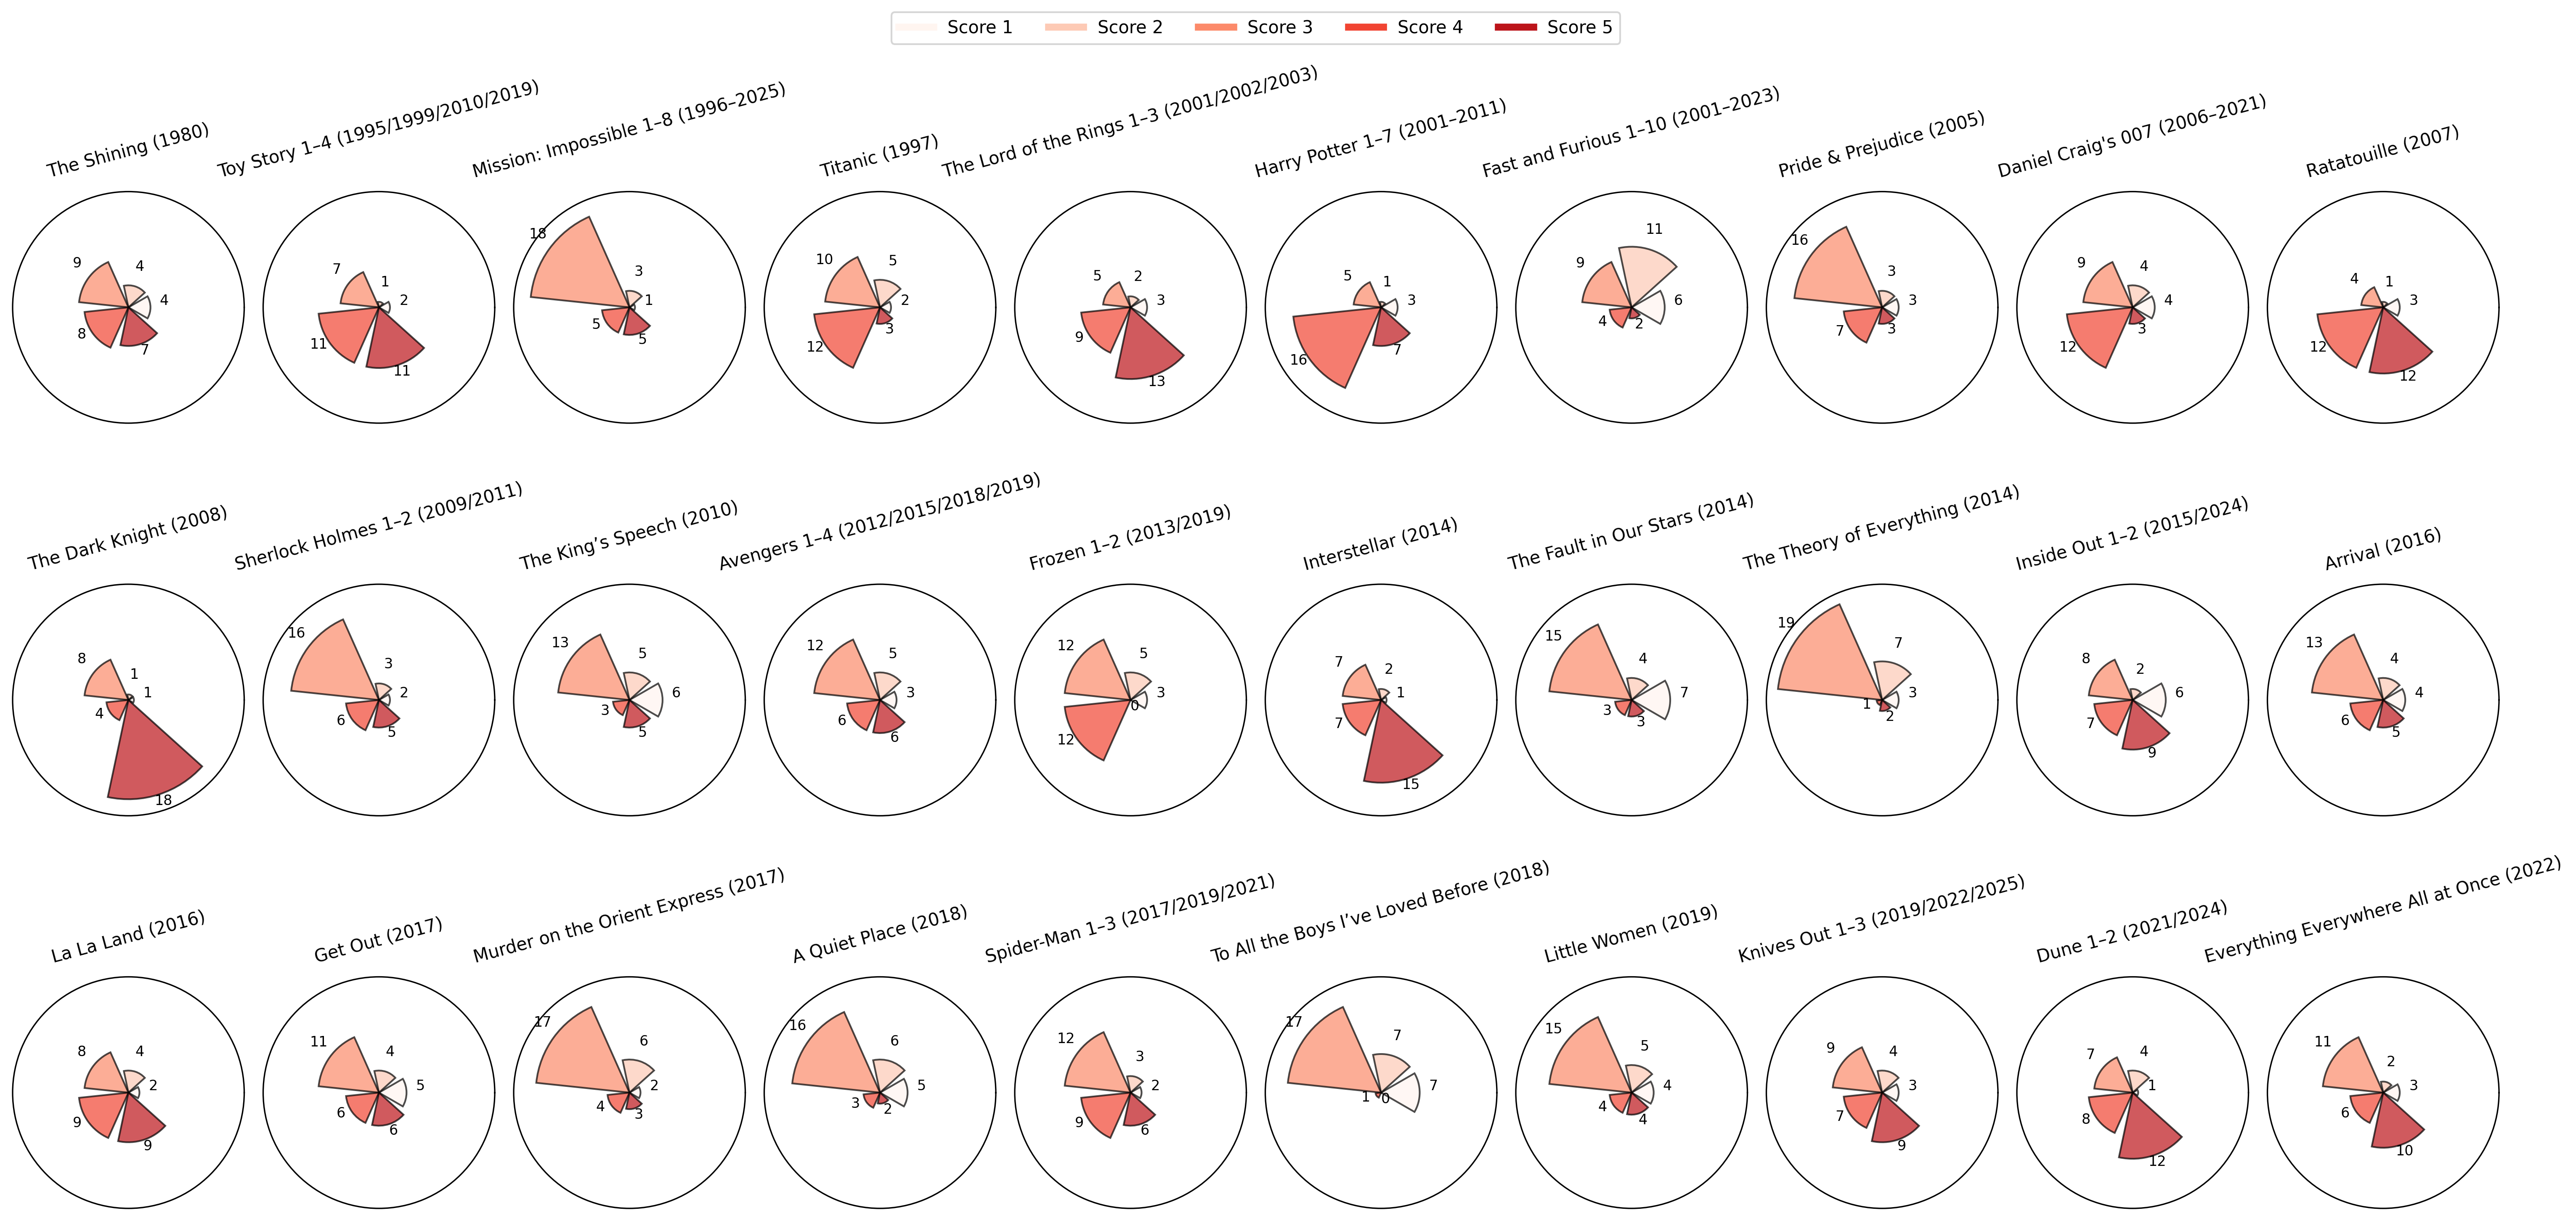

In [6]:
# Set colormap
colormap = plt.cm.Reds

# Create a figure with polar subplots
fig, axes = plt.subplots(3, 10, figsize=(20, 10), subplot_kw={'projection': 'polar'}, dpi=300)

# Flatten the axes array for easier prettifying
axes = axes.flatten()

# Loop over each movie and its corresponding vote counts
for i, (movie, counts) in enumerate(votes_per_score.iterrows()):
    # Create the angles for the rose plot
    angles = np.linspace(0, 2 * np.pi, len(counts), endpoint=False).tolist()
    angles += angles[:1]  # to close the circle

    # Close the counts circle
    counts = counts.tolist() + [counts.iloc[0]]

    # Plot the rose diagram
    ax = axes[i]
    bars = ax.bar(angles[:-1], counts[:-1], width=2 * np.pi / len(counts), color=colormap(np.linspace(0, 1, len(counts))), edgecolor='black', alpha=0.7)

    # Formatting
    for angle, count in zip(angles[:-1], counts[:-1]):
        ax.text(angle, count + 2.5, str(count), ha='center', va='bottom', fontsize=8, color='black')
    ax.set_title(movie, fontsize=10, va='bottom', rotation=15, ha='center')
    ax.set_ylim(0, 21)
    ax.set_yticks([])
    ax.set_xticks([])

# Prettify
legend_labels = ['Score 1', 'Score 2', 'Score 3', 'Score 4', 'Score 5']
legend_colors = [colormap(i / 5) for i in range(5)]
legend_patches = [plt.Line2D([0], [0], color=color, lw=4) for color in legend_colors]
fig.legend(legend_patches, legend_labels, loc='upper center', ncol=5, fontsize=10, bbox_to_anchor=(0.5, 1.025))
for j in range(len(votes_per_score), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

/var/folders/dc/yjt5l_9s0d752c4rt46gd2qh0000gn/T/ipykernel_42998/1674285288.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  pcm = ax.pcolormesh(Theta, R, C, cmap="inferno", shading="auto")


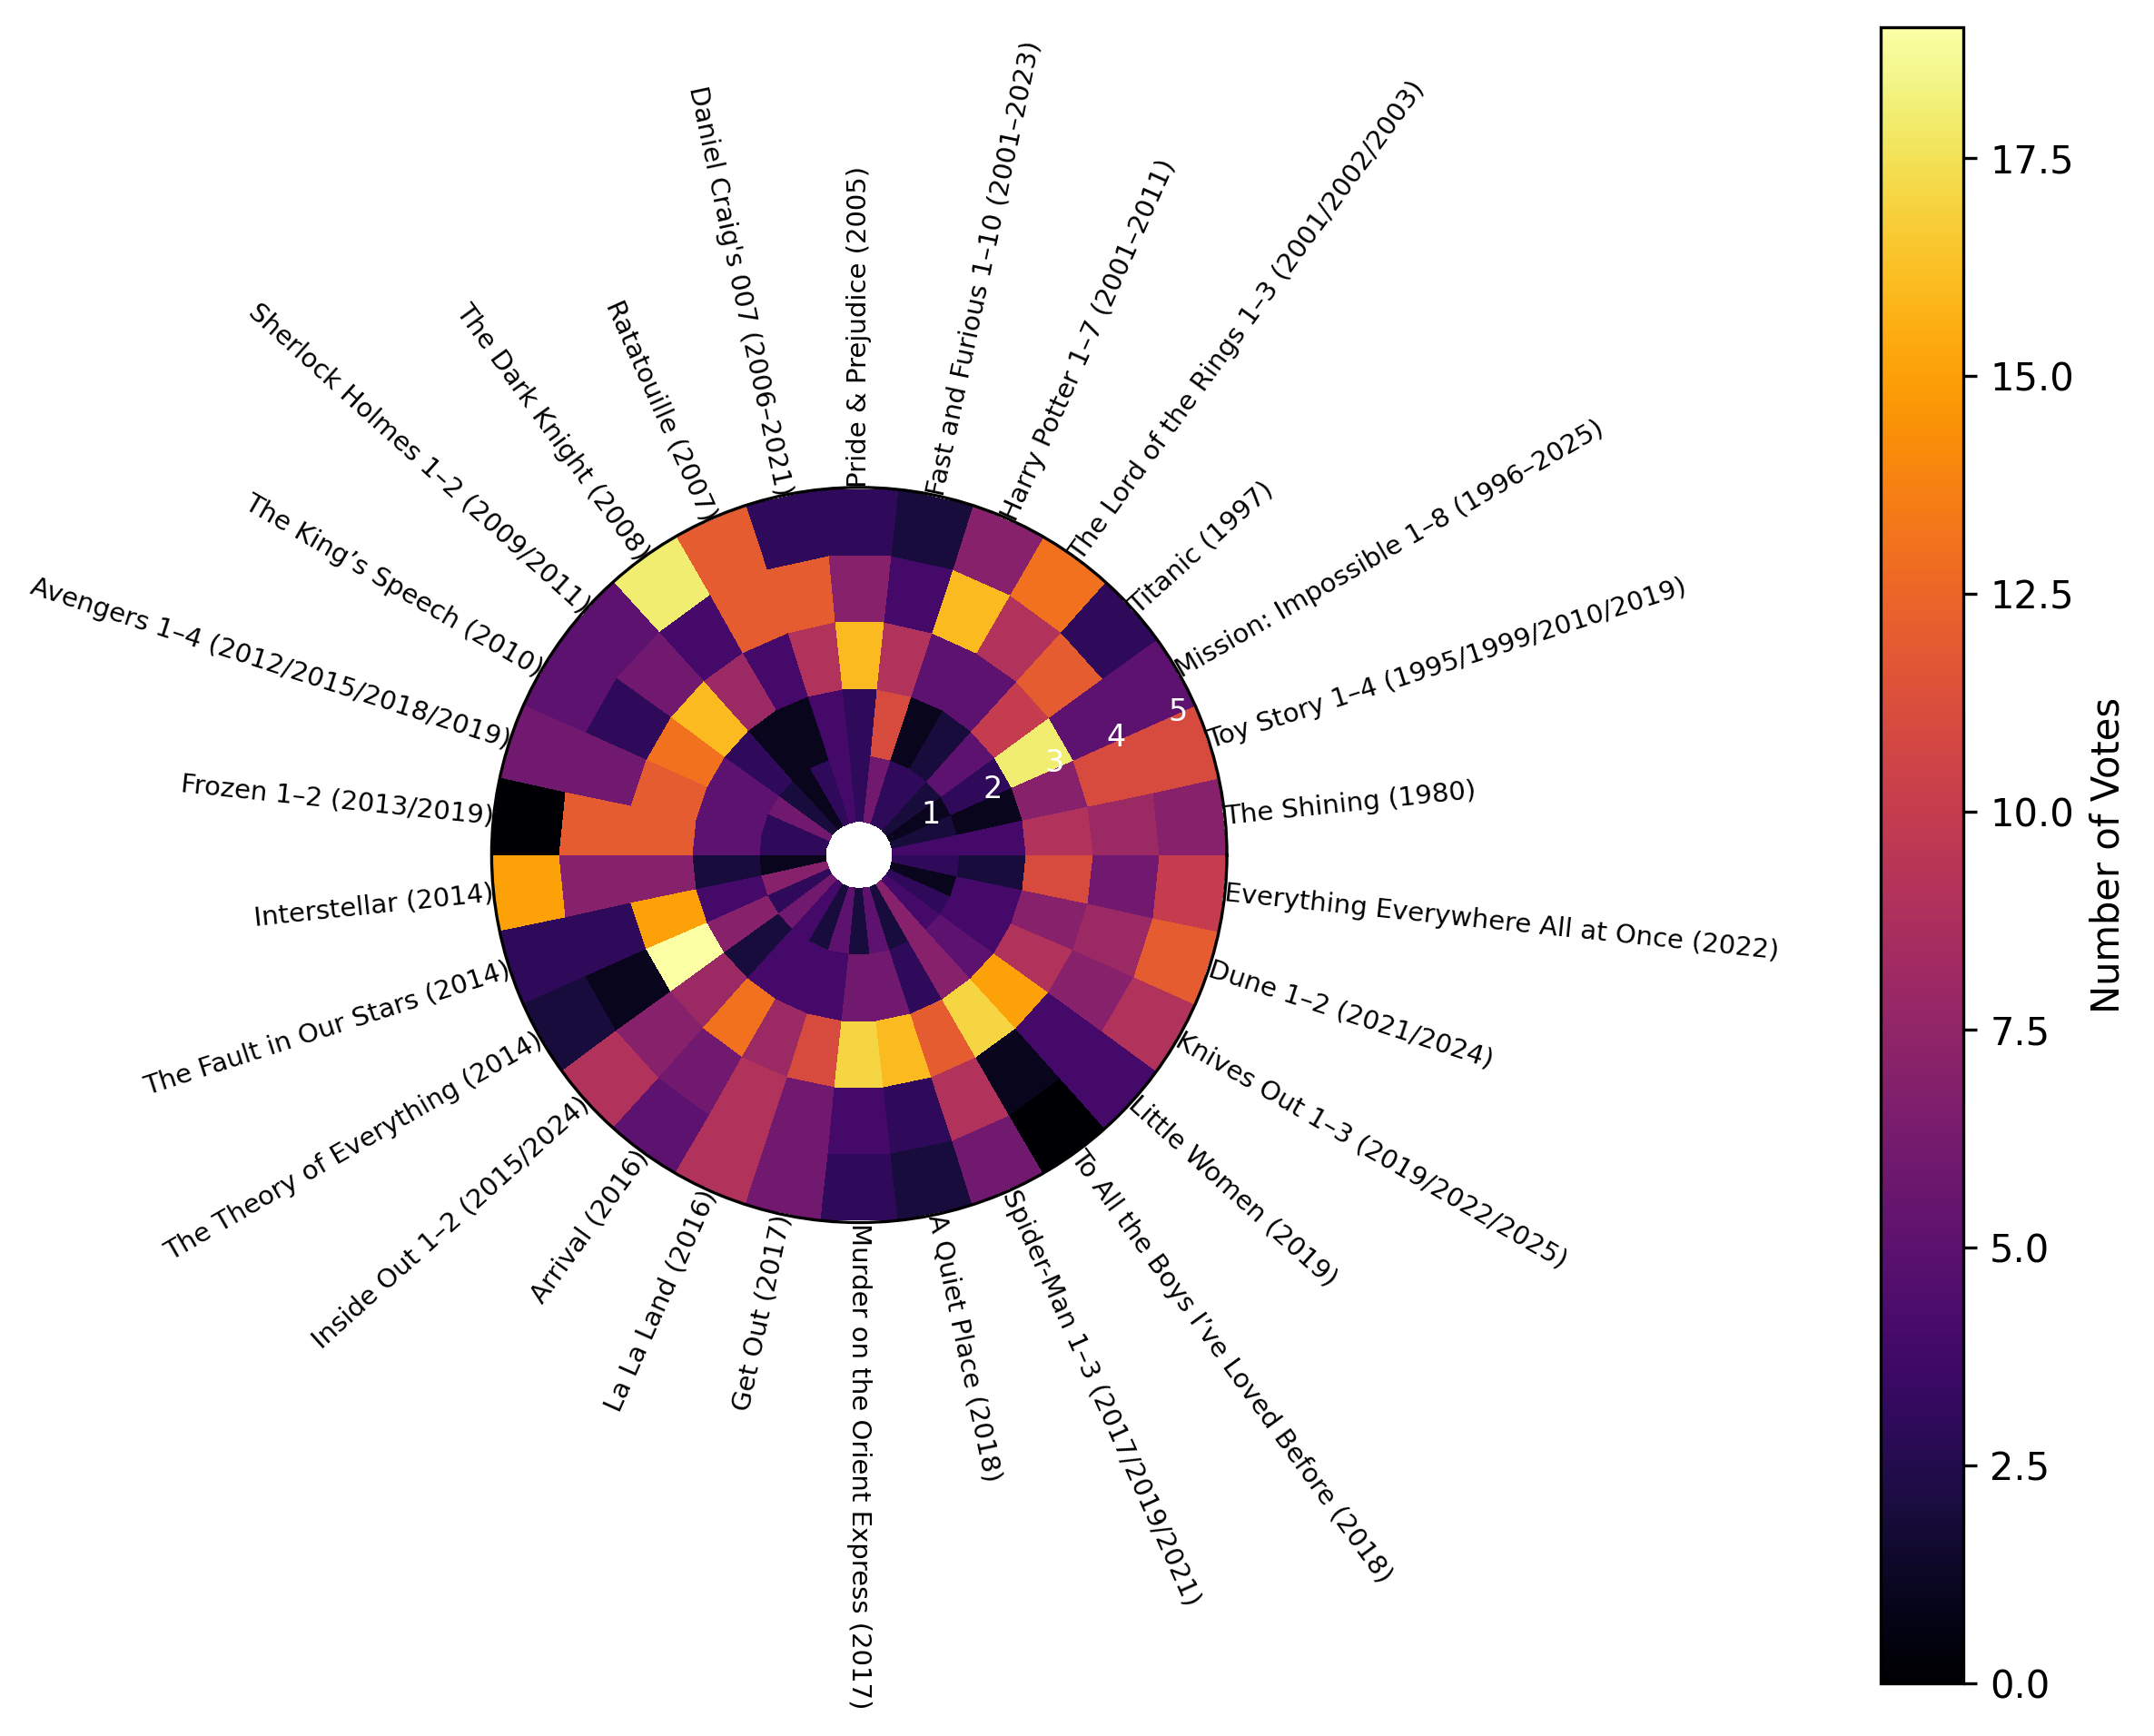

In [7]:
# C matrix: votes for each score (radial) across movies (angular)
C = votes_per_score.T.values
num_scores, num_movies = C.shape

# Define edges
theta = np.linspace(0, 2 * np.pi, num_movies + 1)  # angular edges (movies)
r = np.arange(0.5, num_scores + 1.5, 1)            # radial edges (scores)

Theta, R = np.meshgrid(theta, r)

# Plot
fig, ax = plt.subplots(subplot_kw={"projection": "polar"}, figsize=(8, 8), dpi=300)
pcm = ax.pcolormesh(Theta, R, C, cmap="inferno", shading="auto")

# Colorbar
cbar = plt.colorbar(pcm, ax=ax, pad=0.4, shrink=0.8)
cbar.set_label("Number of Votes")

# Radial ticks (scores)
ax.set_yticks(np.arange(1, num_scores + 1))
ax.set_yticklabels([f"{i}" for i in range(1, num_scores + 1)], color='white', fontsize=8)

# Angular ticks (movies)
angles = (theta[:-1] + theta[1:]) / 2
ax.set_xticks(angles)
ax.set_xticklabels(votes_per_score.index, fontsize=7)

# Formatting
# Radially aligned annotations for movie names
angles = (theta[:-1] + theta[1:]) / 2  # center of each wedge
for angle, movie_name in zip(angles, votes_per_score.index):
    angle_deg = np.degrees(angle)
    
    # Flip labels if on left side of polar plot
    if 90 < angle_deg < 270:
        rotation = angle_deg + 180
        ha = 'right'
    else:
        rotation = angle_deg
        ha = 'left'
    
    ax.text(angle, num_scores + 0.5, movie_name, 
            rotation=rotation, rotation_mode='anchor', 
            ha=ha, va='center', fontsize=7)
# Hide the default tick labels
ax.set_xticklabels([])
# Adjust rotation to align with the x-axis
for label, angle in zip(ax.get_xticklabels(), (theta[:-1] + theta[1:]) / 2):
    angle_deg = np.degrees(angle)
    label.set_rotation(angle_deg - 90)
    label.set_horizontalalignment('center')

# ax.set_title("Votes Distribution Across Scores", va="bottom")
ax.grid(False)
plt.tight_layout()
plt.show()

## SVD

Now let us perform the SVD of the data.

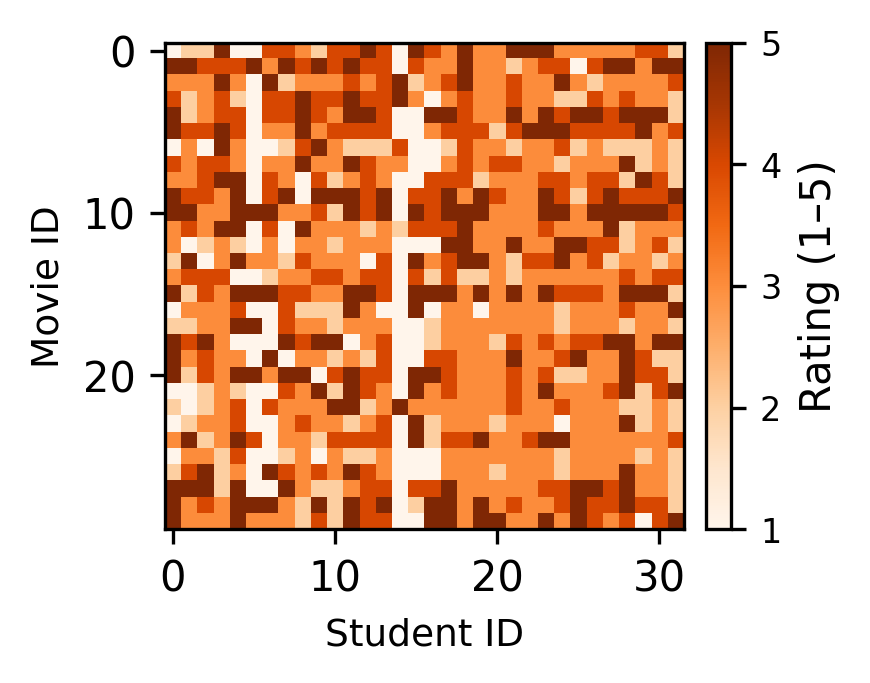

In [15]:
# Set A to be ratings matrix: shape (n_movies, n_students)
A = data.values.T

fig, ax = plt.subplots(figsize=(3, 3), dpi=300)
im = ax.imshow(A, aspect='equal', cmap='Oranges')

# Formatting
ax.set_xlabel('Student ID', fontsize=9)
ax.set_ylabel('Movie ID', fontsize=9)
cbar = plt.colorbar(im, ax=ax, fraction=0.043, pad=0.04)
cbar.set_label('Rating (1–5)')
cbar.ax.tick_params(labelsize=8)
cbar.set_ticks([1, 2, 3, 4, 5])

plt.tight_layout()
plt.show()


Filtered out indices: [6, 15, 16]


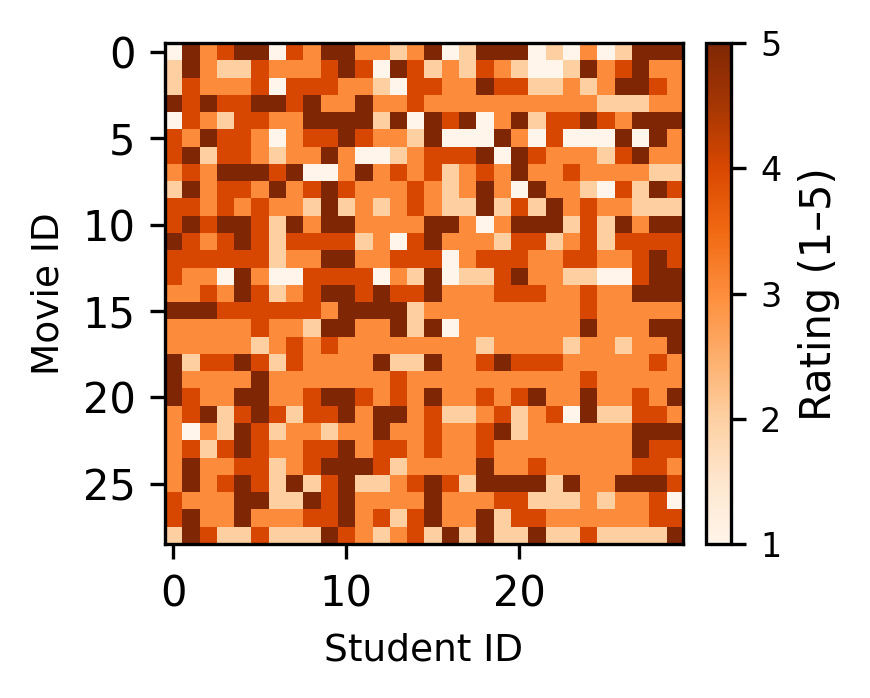

In [16]:
# Filter rows where the count of 1s is less than or equal to 10
filtered_data = data[data.apply(lambda row: (row == 1).sum() <= 10, axis=1)]
filtered_out_indices = data.index.difference(filtered_data.index)
print('Filtered out indices:', filtered_out_indices.tolist())

# Create the AA matrix
AA = filtered_data.values

fig, ax = plt.subplots(figsize=(3, 3), dpi=300)
im = ax.imshow(AA, aspect='equal', cmap='Oranges')

# Formatting
ax.set_xlabel('Student ID', fontsize=9)
ax.set_ylabel('Movie ID', fontsize=9)
cbar = plt.colorbar(im, ax=ax, fraction=0.0443, pad=0.04)
cbar.set_label('Rating (1–5)')
cbar.ax.tick_params(labelsize=8)
cbar.set_ticks([1, 2, 3, 4, 5])

plt.tight_layout()
plt.show()

In [10]:
# SVD
U, s, VT = np.linalg.svd(A)

print("U shape:", U.shape)
print("S shape:", s.shape)
print("VT shape:", VT.shape)

U shape: (30, 30)
S shape: (30,)
VT shape: (32, 32)


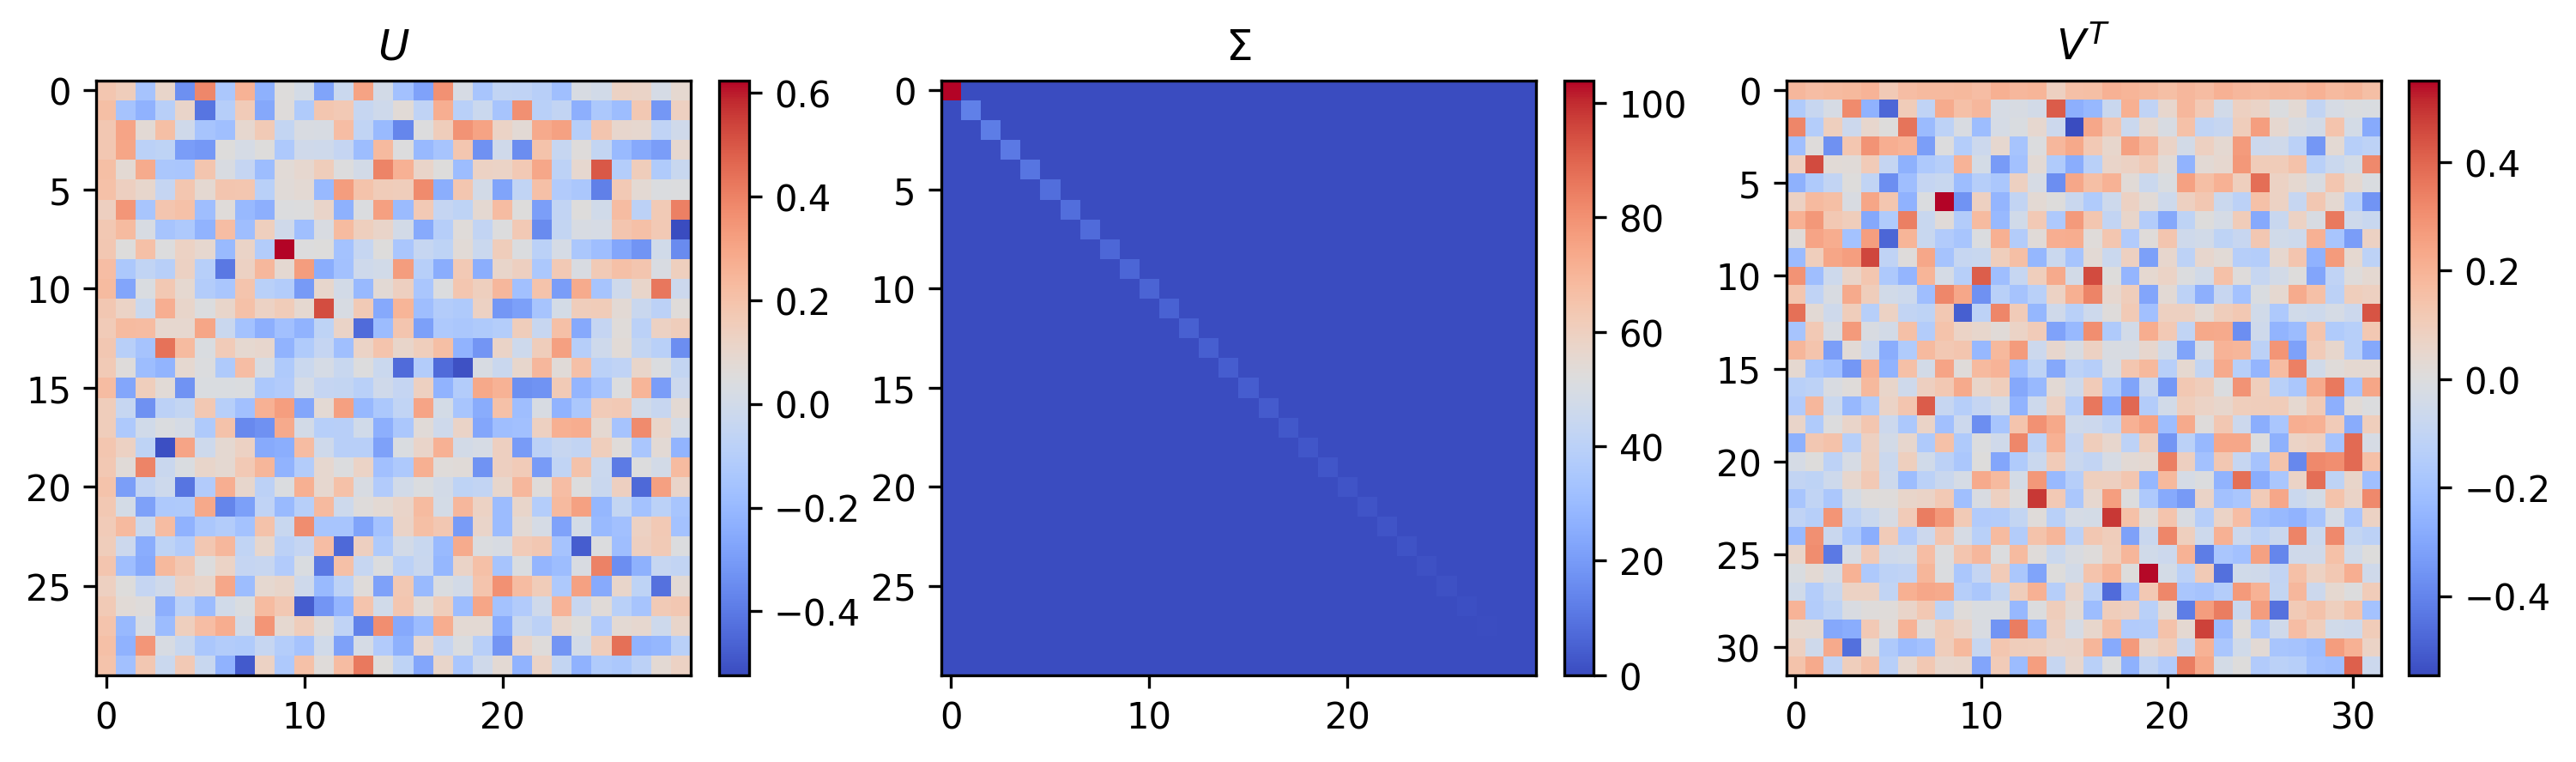

In [11]:
# Create a figure with subplots for U, S, and VT
fig, axes = plt.subplots(1, 3, figsize=(12, 3), dpi=300)

# Plot the U matrix
im_u = axes[0].imshow(U, aspect='auto', cmap='coolwarm')
axes[0].set_title('$U$')
fig.colorbar(im_u, ax=axes[0], fraction=0.046, pad=0.04)

# Plot the S matrix
S = np.diag(s)
im_s = axes[1].imshow(S, aspect='auto', cmap='coolwarm')
axes[1].set_title('$\Sigma$')
fig.colorbar(im_s, ax=axes[1], fraction=0.046, pad=0.04)

# Plot the VT matrix
im_vt = axes[2].imshow(VT, aspect='auto', cmap='coolwarm')
axes[2].set_title('$V^T$')
fig.colorbar(im_vt, ax=axes[2], fraction=0.046, pad=0.04)

# Prettify
for ax in axes:
    ax.set_aspect('equal')

plt.show()

## PCA: movie clustering

We can also apply PCA to the movie rating dataset to identify clusters of movies. In particular, we can examine which movies tend to be liked by similar groups of students, revealing patterns in shared preferences.

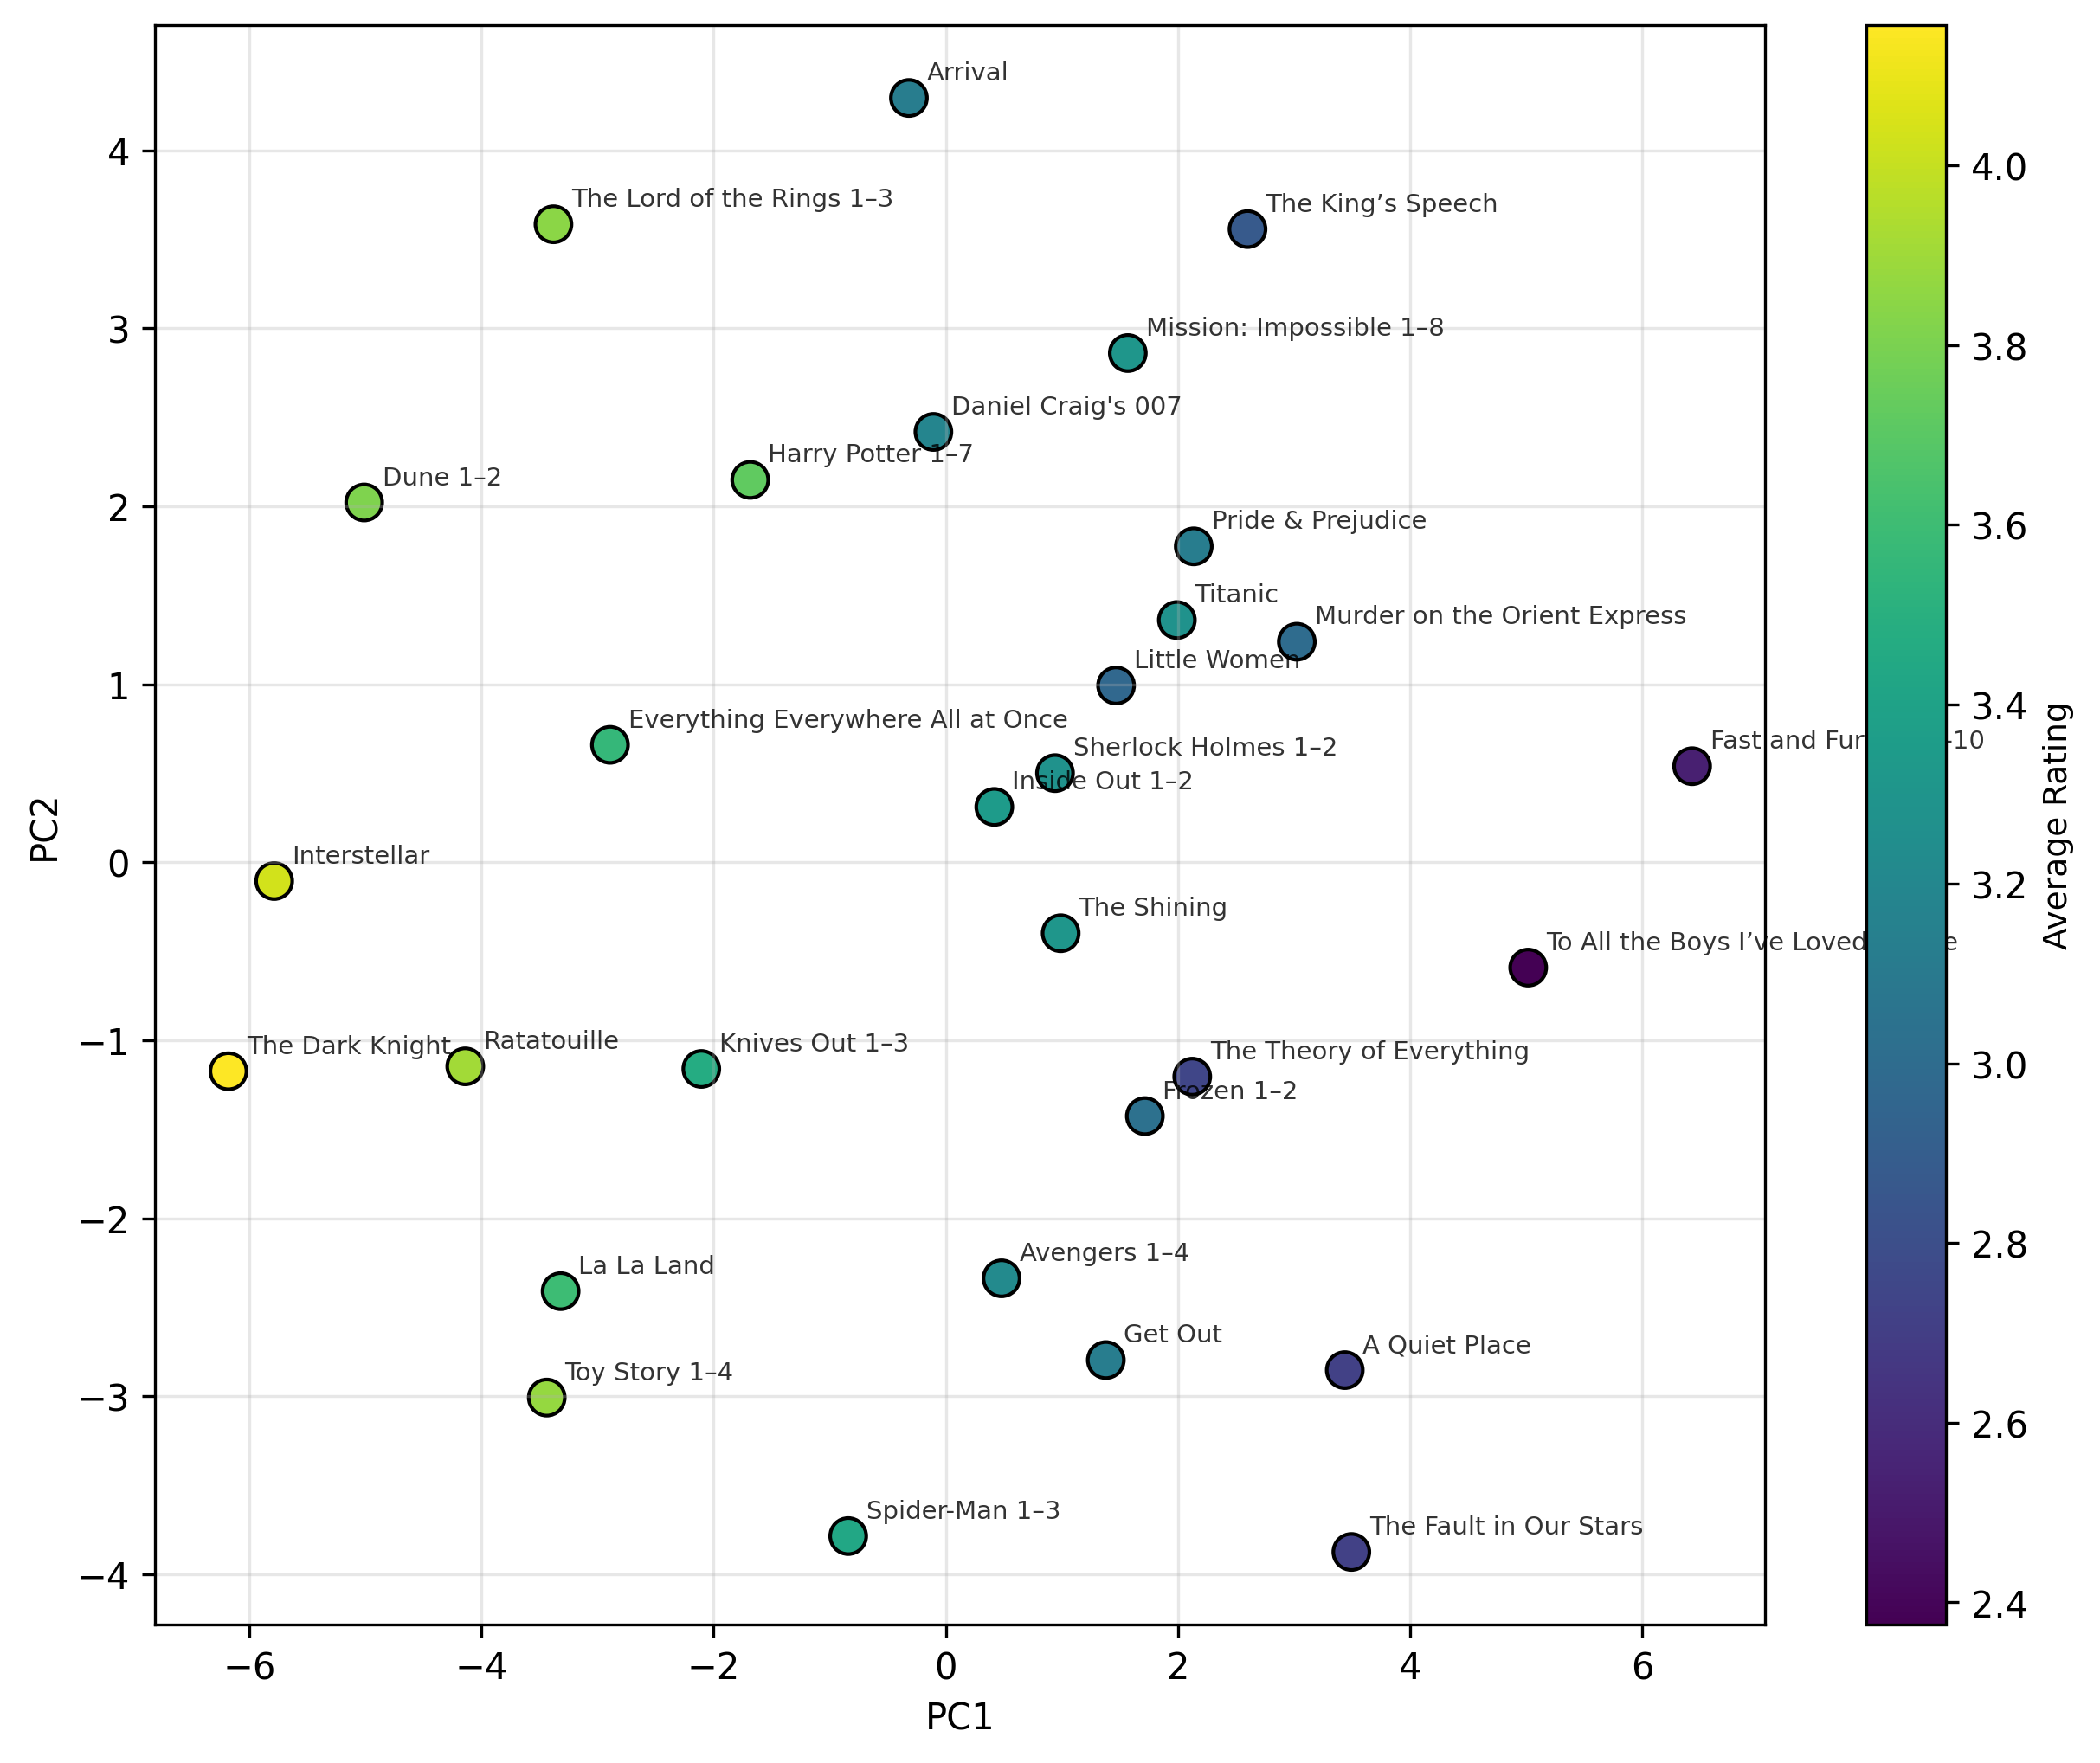

PC1 explains 24.34% of variance
PC2 explains 12.26% of variance
Total explained by PC1 and PC2: 36.59%


In [ ]:
# Construct the mean-centered data matrix
Abar = A.mean(axis=0)
B = A - Abar

# SVD
U, s, VT = np.linalg.svd(B, full_matrices=False)

# Project movies onto the first 2 principal components
movie_pca = U[:, :2] * s[:2]

# Create scatter plot
fig, ax = plt.subplots(figsize=(10, 8), dpi=300)

scatter = ax.scatter(movie_pca[:, 0], movie_pca[:, 1], 
                     c=avg_scores, cmap='viridis', 
                     s=100, edgecolors='black')

# Formatting
for i, movie in enumerate(data.columns):
    clean_title = re.sub(r'\s*\(.*', '', movie)
    ax.annotate(
        clean_title,
        (movie_pca[i, 0], movie_pca[i, 1]),
        fontsize=7,
        alpha=0.8,
        xytext=(5, 5),
        textcoords='offset points'
    )
ax.set_xlabel('PC1', fontsize=10)
ax.set_ylabel('PC2', fontsize=10)
ax.grid(alpha=0.3)
# Colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Average Rating', fontsize=9)

plt.show()

# Print explained variance
eigenvalues = s**2
explained_variance_ratio = eigenvalues / eigenvalues.sum()
print(f'PC1 explains {explained_variance_ratio[0]:.2%} of variance')
print(f'PC2 explains {explained_variance_ratio[1]:.2%} of variance')
print(f'Total explained by PC1 and PC2: {explained_variance_ratio[:2].sum():.2%}')

## Predict movie scores

One thing we can do with SVD is use it to predict movie ratings for people who have not yet seen certain movies. In the dataset, we filtered out students who gave a rating of 1 to more than 10 movies, as this likely indicates that they had not actually watched those movies. However, we can use SVD to predict their possible ratings based on the latent patterns in the existing data.

In [ ]:
# Low-rank approximation
r = 5
U_r = U[:, :r]
s_r = s[:r]
VT_r = VT[:r, :]

# Store predicted ratings for missing movies
predicted_ratings_dict = {}

for student_id in filtered_out_indices:
    
    # Student original ratings
    student_ratings = data.loc[student_id]
    movies_rated_1 = student_ratings[student_ratings == 1].index.tolist()
    
    # Low-rank reconstruction
    predicted_centered = (U_r[student_id-1, :] * s_r) @ VT_r # -1 because student_id starts from 1
    predicted_rating = predicted_centered + Abar
    
    # Store predictions only for missing movies
    for movie in movies_rated_1:
        movie_idx = data.columns.get_loc(movie)
        predicted_rating_value = predicted_rating[movie_idx]
        predicted_ratings_dict[(student_id, movie)] = predicted_rating_value

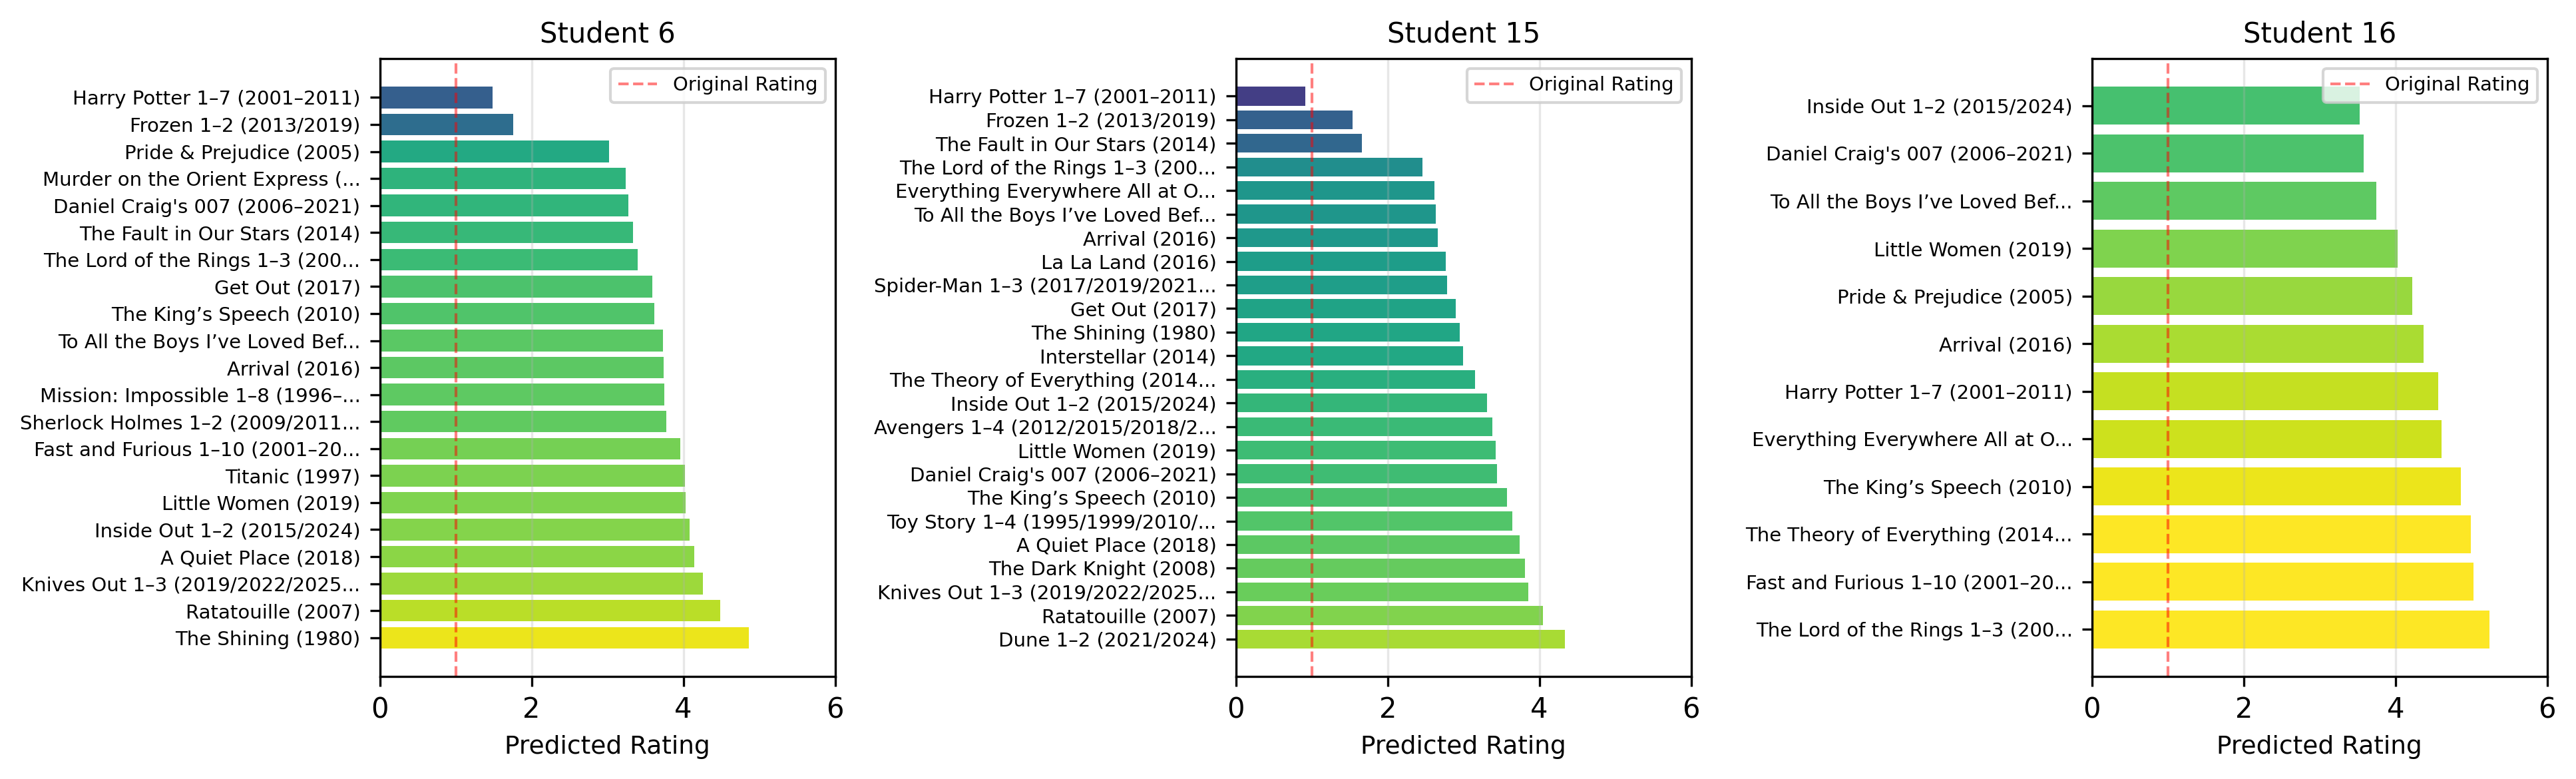

In [25]:
# Convert predicted_ratings_dict to DataFrame
prediction_results = []
for (student_id, movie), predicted_rating in predicted_ratings_dict.items():
    original_rating = data.loc[student_id, movie]
    prediction_results.append({
        'Student ID': student_id,
        'Movie': movie,
        'Original Rating': original_rating,
        'Predicted Rating': round(predicted_rating, 2)
    })
predictions_df = pd.DataFrame(prediction_results)

# Plot predicted ratings for each filtered out student
fig, axes = plt.subplots(1, 3, figsize=(13, 4), dpi=300)

for idx, student in enumerate(filtered_out_indices):
    student_predictions = predictions_df[predictions_df['Student ID'] == student]
    
    # Sort by predicted rating
    student_predictions_sorted = student_predictions.sort_values('Predicted Rating', ascending=False)
    
    # Create bar chart
    bars = axes[idx].barh(range(len(student_predictions_sorted)), 
                           student_predictions_sorted['Predicted Rating'],
                           color=plt.cm.viridis(student_predictions_sorted['Predicted Rating'] / 5))
    
    # Formatting
    axes[idx].set_yticks(range(len(student_predictions_sorted)))
    axes[idx].set_yticklabels([movie[:30] + '...' if len(movie) > 30 else movie 
                                for movie in student_predictions_sorted['Movie']], fontsize=7)
    axes[idx].set_xlabel('Predicted Rating', fontsize=9)
    axes[idx].set_title(f'Student {student}', fontsize=10)
    axes[idx].set_xlim(0, 6)
    axes[idx].axvline(x=1, color='red', linestyle='--', alpha=0.5, linewidth=1, label='Original Rating')
    axes[idx].grid(axis='x', alpha=0.3)
    axes[idx].legend(fontsize=7)

plt.tight_layout()
plt.show()

Disclaimer: This is a very hand-wavy prediction and the max rating is not capped!